# Surface Mapping using Apriltags

In this notebook, we show how to use AprilTags to map from gaze-to screen coordinates. Along the way, we will also show some additional epoching functionalities.

To do so, we have collected a dataset where a participant freely views artworks presented on screen. Each artwork is shown for 4s, followed by a 0.5s inter trial intervall and a 0.5s central fixation cross. We can download this dataset using `get_sample_data()`.

In [1]:
from pyneon import Dataset, get_sample_data
import matplotlib.pyplot as plt

# Load a sample recording
dataset_dir = get_sample_data("markers", format="native")
dataset = Dataset(dataset_dir)

D:\GitHub\PyNeon\pyneon\recording.py:164: UserWarning: Recording 16841adb-da58-4c42-be02-f052c3c43db3 misses the following expected files:
blinks ps1.raw
blinks ps1.time
eye_state ps1.raw
eye_state ps1.time
fixations ps1.raw
fixations ps1.time
  warn(
D:\GitHub\PyNeon\pyneon\recording.py:164: UserWarning: Recording c17cd630-764e-4e61-87ee-95be3d6b8181 misses the following expected files:
blinks ps1.raw
blinks ps1.time
eye_state ps1.raw
eye_state ps1.time
fixations ps1.raw
fixations ps1.time
  warn(


We have two recordings. One recording used AprilTags as markers and presented in total 40 images. The second recording used ArUco markers and presented in total 5 images. We will first focus on the AprilTag recording and later show how to use the ArUco markers for surface mapping with a similar workflow.

In [2]:
rec = dataset.recordings[1]
print(rec)


Data format: native
Recording ID: c17cd630-764e-4e61-87ee-95be3d6b8181
Wearer ID: b84a9140-ffb5-489e-a050-66fe3930ea6c
Wearer name: Maksim
Recording start time: 2025-09-22 00:31:44.395000
Recording duration: 35977000000 ns (35.977 s)



Let us take a closer look at the events file, populated with triggers sent during the initial viewing

We can see that the name column holds the information ofinterest to us. As the column ontains both information about the event_type as well as its name, we will first parse these apart. This process is a bit lengthy, but necessary to make sense of our data

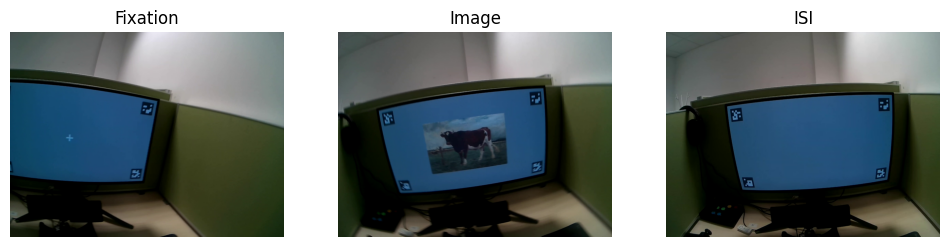

In [24]:
video = rec.scene_video

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
video.plot_frame(80, ax=axs[0], show=False)
video.plot_frame(140, ax=axs[1], show=False)
video.plot_frame(240, ax=axs[2], show=False)
axs[0].set_title("Fixation")
axs[1].set_title("Image")
axs[2].set_title("ISI")
plt.show()

In all of the frames shown above, we can see QR-code like markers at the borders of the screen. These are called apriltags and can be used as fiducial markers to relate video to real-world coordinates. PyNeon wraps a function that performs the detection of these. For computational efficiency, we only perform one detection every 30 frames.

In [21]:
detected_markers = video.detect_markers(
    "5x5_250", detection_window_unit="frame"
)

Detecting markers: 100%|██████████| 971/971 [01:21<00:00, 11.98it/s]


In [22]:
detected_markers.data.loc[detected_markers.ts[0]]

frame index                    0
marker family            5x5_250
marker id                      0
marker name            5x5_250_0
top left x [px]            512.0
top left y [px]            524.0
top right x [px]           578.0
top right y [px]           514.0
bottom right x [px]        592.0
bottom right y [px]        582.0
bottom left x [px]         531.0
bottom left y [px]         591.0
center x [px]             553.25
center y [px]             552.75
Name: 1758493907028897307, dtype: object

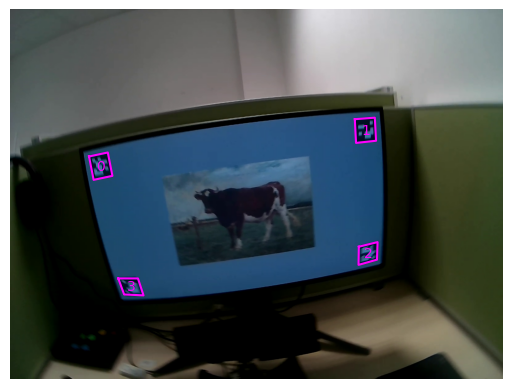

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [25]:
# Only get markers detected in frame
frame = 140
video.plot_detected_markers(detected_markers, frame_index=frame)

Having detected the markers (apriltags), we now need to provide information on the real-world coordinates of our markers. This is solved via a marker_info dataframe, which we generate below.

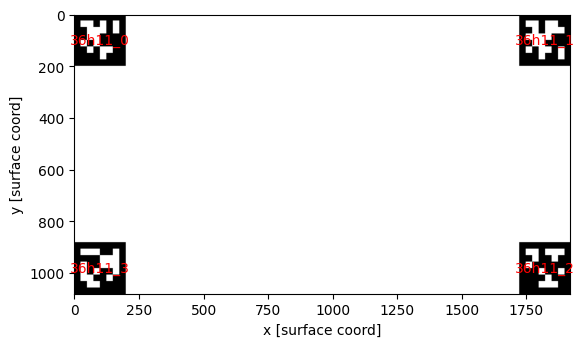

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='x [surface coord]', ylabel='y [surface coord]'>)

In [ ]:
from pyneon.vis import plot_marker_layout
import pandas as pd

marker_layout = pd.DataFrame(
    {
        "marker name": [f"36h11_{i}" for i in range(4)],
        "size": 200,
        "center x": [100, 1820, 1820, 100],
        "center y": [100, 100, 980, 980],
    }
)
print(marker_layout)
plot_marker_layout(marker_layout)

With this, we can now run the ``find_homograpghy()`` method. This method finds the map between the detections and the provided coordinates for each frame. As we did not do detections in every frame, we further provide the skip_frames as used before so that the homographies can be interpolated.

In [9]:
# cast index to np.ndarray
index = rec.gaze.data.index.to_numpy()
print(index[:10])

[1758493906829570307 1758493906839570307 1758493906844570307
 1758493906849577307 1758493906854570307 1758493906859569307
 1758493906864570307 1758493906869569307 1758493906874569307
 1758493906879569307]


In [28]:
from pyneon.video import find_homographies

homographies = find_homographies(
    detected_markers,
    marker_layout,
)

Computing homographies:   0%|          | 0/870 [00:00<?, ?it/s]


AttributeError: 'Series' object has no attribute 'iterrows'

with this, we can finally transform both gaze and fixation coordinates into the screen's reference frame:

In [ ]:
gaze_on_screen = rec.gaze_on_surface(homographies=homographies, overwrite=True)
fixations_on_screen = rec.fixations_on_surface(
    gaze_on_surface=gaze_on_screen, overwrite=True
)

In [ ]:
gaze_data = gaze_on_screen.data
fix_data = fixations_on_screen.data

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(
    gaze_data["gaze x [surface coord]"],
    gaze_data["gaze y [surface coord]"],
    s=1,
    alpha=0.5,
    c=gaze_data.index,
    cmap="viridis",
)

plt.scatter(
    fix_data["fixation x [surface coord]"],
    fix_data["fixation y [surface coord]"],
    s=1,
    c="black",
    label="Fixations",
)

plt.plot(
    [-600, 600, 600, -600, -600],
    [-400, -400, 400, 400, -400],
    color="red",
    label="Image outline",
)

plt.xlabel("X Coordinate (surface coord)")
plt.ylabel("Y Coordinate (surface coord)")

plt.xlim(-800, 800)
plt.ylim(-600, 600)